<a href="https://colab.research.google.com/github/aradyzah/Analisis-Pengguna-Shopee-pada-Platform-X/blob/main/AnalisisJejaring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import networkx as nx
import re

# Baca data
df = pd.read_csv('/content/drive/MyDrive/shopee_cleaned.csv')

print(df.columns)


Index(['conversation_id_str', 'created_at', 'favorite_count', 'full_text',
       'id_str', 'in_reply_to_screen_name', 'retweet_count', 'user_id_str',
       'username', 'cleaned_text'],
      dtype='object')


In [ ]:
# buat engagement
df['engagement'] = df['retweet_count'] + df['favorite_count']

# Urutkan berdasan total interaksi
influencers = df.groupby('user_id_str')['engagement'].sum().sort_values(ascending=False).head(10)
print("Top 10 pengguna paling berpengaruh (berdasarkan user_id_str):")
print(influencers)


Top 10 pengguna paling berpengaruh (berdasarkan user_id_str):
user_id_str
468432710      3273
1,32679E+18     494
1,44616E+18     232
1,74255E+18     174
397027513       122
1,70606E+18      87
8,2602E+17       61
1,79409E+18      61
1,80621E+18      58
1,7958E+18       58
Name: engagement, dtype: int64


In [ ]:
edges = []

# 1. Hubungan reply
reply_edges = df[df['in_reply_to_screen_name'].notna()][['user_id_str', 'in_reply_to_screen_name']]
for _, row in reply_edges.iterrows():
    edges.append((str(row['user_id_str']), str(row['in_reply_to_screen_name'])))

# 2. Hubungan mention di teks
for _, row in df.iterrows():
    mentions = re.findall(r'@([A-Za-z0-9_]+)', str(row['full_text']))
    for mention in mentions:
        edges.append((str(row['user_id_str']), mention))

# Buat graf
G = nx.DiGraph()
G.add_edges_from(edges)

print(f"Total node: {len(G.nodes())}")
print(f"Total edge: {len(G.edges())}")


Total node: 634
Total edge: 394


In [ ]:
# Hitung sentralitas
degree_centrality = nx.degree_centrality(G)
betweenness = nx.betweenness_centrality(G)

centrality_df = pd.DataFrame({
    'user': list(degree_centrality.keys()),
    'degree': list(degree_centrality.values()),
    'betweenness': list(betweenness.values())
})

# Top 10 pengguna paling sentral
centrality_df = centrality_df.sort_values(by='degree', ascending=False).head(10)
print(centrality_df)


            user    degree  betweenness
281   tanyakanrl  0.011058          0.0
53      60196625  0.011058          0.0
80      ShopeeID  0.011058          0.0
244   2983890506  0.007899          0.0
413      sbyfess  0.007899          0.0
223  1,53727E+18  0.007899          0.0
227   tanyarlfes  0.007899          0.0
91   1,81055E+18  0.007899          0.0
57    Shopee__ID  0.007899          0.0
257  1,05421E+18  0.006319          0.0


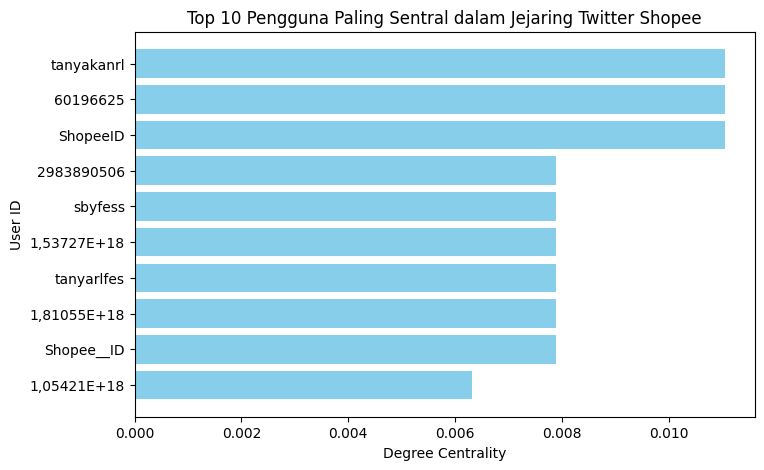

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.barh(centrality_df['user'].astype(str), centrality_df['degree'], color='skyblue')
plt.xlabel('Degree Centrality')
plt.ylabel('User ID')
plt.title('Top 10 Pengguna Paling Sentral dalam Jejaring Twitter Shopee')
plt.gca().invert_yaxis()
plt.show()


In [ ]:
!pip install python-louvain
import community.community_louvain as community_louvain

partition = community_louvain.best_partition(G.to_undirected())
nx.set_node_attributes(G, partition, 'community')


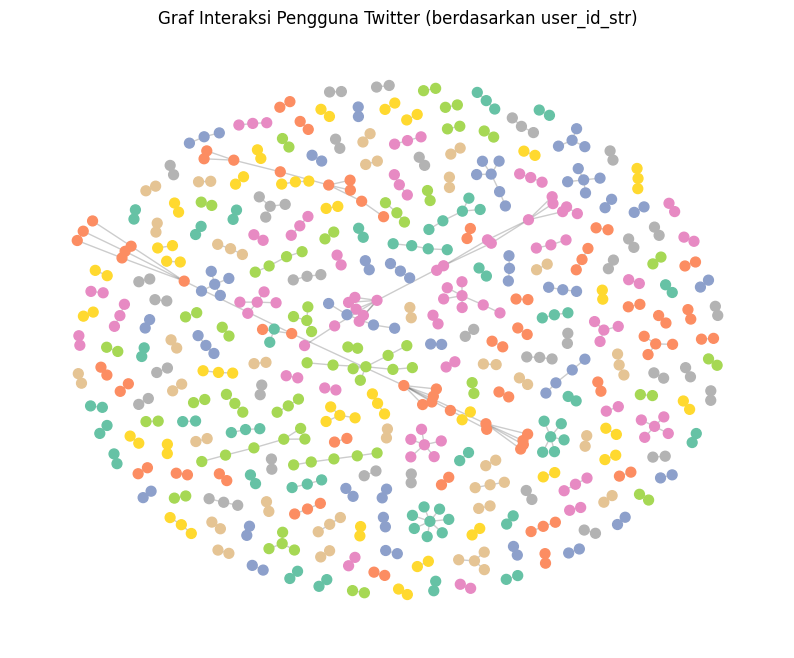

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
pos = nx.spring_layout(G, k=0.3, seed=42)
communities = [partition[node] for node in G.nodes()]

nx.draw_networkx_nodes(G, pos, node_size=50, cmap=plt.cm.Set2, node_color=communities)
nx.draw_networkx_edges(G, pos, alpha=0.2, arrows=False)

plt.title("Graf Interaksi Pengguna Twitter (berdasarkan user_id_str)")
plt.axis('off')
plt.show()

Top 10 pengguna paling berpengaruh:
user_id_str
468432710      3273
1,32679E+18     494
1,44616E+18     232
1,74255E+18     174
397027513       122
1,70606E+18      87
8,2602E+17       61
1,79409E+18      61
1,80621E+18      58
1,7958E+18       58
Name: engagement, dtype: int64


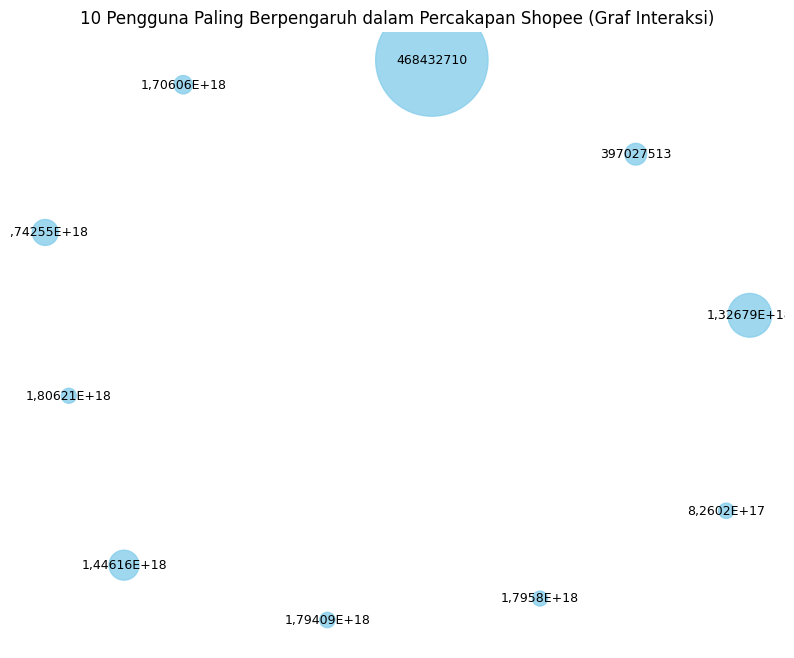

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import re

#  Baca data
df = pd.read_csv('/content/drive/MyDrive/shopee_cleaned.csv')

# Pastikan engagement sudah dihitung
df['engagement'] = df['retweet_count'] + df['favorite_count']

# Ambil 10 pengguna paling berpengaruh (berdasarkan user_id_str)
top_users = df.groupby('user_id_str')['engagement'].sum().sort_values(ascending=False).head(10)
print("Top 10 pengguna paling berpengaruh:")
print(top_users)

# Buat graf kecil hanya untuk 10 pengguna teratas
G = nx.DiGraph()

# Tambahkan node untuk 10 pengguna teratas
for user in top_users.index:
    G.add_node(user, size=top_users[user])

# Tambahkan edge antar mereka berdasarkan mention dan reply
for _, row in df.iterrows():
    source = str(row['user_id_str'])
    mentions = re.findall(r'@([A-Za-z0-9_]+)', str(row['full_text']))
    target_reply = str(row['in_reply_to_screen_name'])

    # Tambahkan edge hanya kalau sumber dan target masuk top 10
    for mention in mentions:
        if source in top_users.index and mention in top_users.index:
            G.add_edge(source, mention)
    if source in top_users.index and target_reply in top_users.index:
        G.add_edge(source, target_reply)

#  Atur ukuran node berdasarkan engagement
sizes = [G.nodes[node]['size']*2 for node in G.nodes()]

#  Gambar graf
plt.figure(figsize=(10,8))
pos = nx.spring_layout(G, seed=42)

nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color='skyblue', alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.3, arrows=True)
nx.draw_networkx_labels(G, pos, font_size=9, font_color='black')

plt.title("10 Pengguna Paling Berpengaruh dalam Percakapan Shopee (Graf Interaksi)")
plt.axis('off')
plt.show()


1. https://x.com/meinmokhtar
